In [122]:
%matplotlib inline

In [123]:
import numpy as np
from netCDF4 import Dataset as ds
import matplotlib.pyplot as plt
import matplotlib.table as tbl
from metpy.calc import moist_lapse
from metpy.units import units
import os
import pickle

In [124]:
def plotEQProfiles(ax, eq_q, air_pressure_on_interface_levels, eq_air_temperature, air_pressure):
    ax0 = ax
    ln1 = ax0.plot(eq_q,
             air_pressure, '-o',
             markersize=3, c='b', label='Humidity')
    ax0.set_yscale('log')
    ax0.axes.invert_yaxis()
#     ax0.set_yscale('log')
    ax0.set_xlabel('kg/kg')
    ax0.set_ylabel('Pa')
#     ax0.grid()

    ax0b = ax0.twiny()
    ln2 = ax0b.plot(eq_air_temperature,
             air_pressure, '-o', markersize=3, c='r', label='Temp')
    ax0b.set_xlabel('K')
    
    ### MOIST ADIABAT
    moist_adiabat_Tsurf = eq_air_temperature[0] * units.kelvin
    moist_adiabat_p = air_pressure* units.pascal
    moist_adiabat_profile = moist_lapse(moist_adiabat_p, moist_adiabat_Tsurf)
    ln3 = ax0b.plot(moist_adiabat_profile,
             air_pressure, '-o', markersize=3, c='k', label='Moist Ad')
    ###
    
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax0b.legend(lns, labs, loc=2)
#     ax0b.grid()

In [126]:
def plotEQvals(ax, eq_pkl):
    ax1 = ax
    ax1.set_xticks([])
    ax1.set_yticks([])
    Tsurf = eq_pkl['surface_temperature'][0,0]
    LH = eq_pkl['surface_upward_latent_heat_flux'][0,0]
    SH = eq_pkl['surface_upward_sensible_heat_flux'][0,0]
    LWsurf = (eq_pkl['upwelling_longwave_flux_in_air']-
              eq_pkl['downwelling_longwave_flux_in_air'])[0, 0, 0]
    SWsurf = (eq_pkl['upwelling_shortwave_flux_in_air']-
              eq_pkl['downwelling_shortwave_flux_in_air'])[0, 0, 0]
    netsurf = LWsurf + SWsurf + LH + SH
    LWtoa = (eq_pkl['upwelling_longwave_flux_in_air']-
             eq_pkl['downwelling_longwave_flux_in_air'])[-1, 0, 0]
    SWtoa = (eq_pkl['upwelling_shortwave_flux_in_air']-
             eq_pkl['downwelling_shortwave_flux_in_air'])[-1, 0, 0]
    nettoa = LWtoa + SWtoa
    Qsurf = eq_pkl['specific_humidity'][0, 0, 0]
    Qtot = np.sum(eq_pkl['specific_humidity'])
    celltext = [['$\\bf{Surface}$', ''],
                ['Tsurf (K)', np.round(Tsurf, 2)],
                ['Qsurf (kg/kg)', np.round(Qsurf, 5)],
                ['LH (Wm^-2)', np.round(LH, 2)],
                ['SH (Wm^-2)', np.round(SH, 2)],
                ['LW (Wm^-2)', np.round(LWsurf, 2)],
                ['SW (Wm^-2)', np.round(SWsurf, 2)],
                ['net surf (Wm^-2)', np.round(netsurf, 2)],
                ['$\\bf{TOA}$', ''],
                ['SWdown (Wm^-2)', np.round(eq_pkl['downwelling_shortwave_flux_in_air'][-1, 0, 0], 2)],
                ['insol (Wm^-2)', -np.round(SWtoa, 2)],
                ['net toa (Wm^-2)', np.round(nettoa, 2)],
                ['$\\bf{Total}$', ''],
                ['Qtot (kg/kg)', np.round(Qtot, 5)]]
    ax1.table(cellText=celltext, cellLoc='center', loc='center', fontsize = 1)

In [137]:
def plotTsurfPrecipLH(ax, time_adj, tsurf, precip, time_title, lh_flux, strat_prec = 'None'):
    ax2 = ax
    precip_flux = precip * (1/86400) * (2556) * (10**3)
    ln1 = ax2.plot(time_adj, precip_flux, '-', c='b', label = 'Precip', linewidth=2)
    ax2.set_title('Precip / Latent Heat')
    ax2.set_xlabel(time_title)
    ax2.grid()
    ln2 = ax2.plot(time_adj, lh_flux, '--', c='y', label = 'LH Flux', linewidth=1)
    ax2.set_ylabel('Wm$^{-2}$')
    
    ax2b = ax2.twinx()
    ln3 = ax2b.plot(time_adj, tsurf, '-.', c='k', label = 'Tsurf')
    ax2b.set_ylabel('K')

    if strat_prec == 'None':
        lns = ln1+ln2+ln3
    else:
        strat_prec_flux = strat_prec * (1/86400) * (2556) * (10**3)
        ln4 = ax2.plot(time_adj, strat_prec, '-', c='r', label = 'StratPrec', linewidth=2)
        lns = ln1+ln2+ln3+ln4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=1)


In [138]:
def plotFluxes(ax, time_adj, net_flux_surface, sh_flux, lh_flux, net_flux_toa, time_title):
    ax3 = ax
    ax3.plot(time_adj, net_flux_surface, c = 'y', label='Rad')
    ax3.plot(time_adj, sh_flux, c = 'r', label = 'SH')
    ax3.plot(time_adj, lh_flux, c = 'b', label = 'LH')
    ax3.plot(time_adj, net_flux_surface + lh_flux + sh_flux, c='#7570b3', label = 'Surf')
    ax3.plot(time_adj, net_flux_toa, c='#d95f02', label='TOA')
    ax3.set_title('Fluxes (Up is +)')
    ax3.set_xlabel(time_title)
    ax3.set_ylabel('Wm$^{-2}$')
    # ax3.set_ylim(-50, 250)
    ax3.legend()
    ax3.grid()

In [145]:
def plotEQResponse(job_name, test_dir = '', save_step=36):
    base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files/'
#     file_name = '{0}/{1}/{1}'.format(base_name, job_name)
    file_name = '{0}{1}{2}/{2}'.format(base_name, test_dir, job_name)
    plot_base = '/Users/haynesstephens1/uchi/research/climproj/climproj/figures/'
#     plot_name = '{0}/{1}/{1}_time_series.pdf'.format(plot_base, job_name)
    plot_dir = '{0}{1}{2}{3}'.format(plot_base, 'EQandTransResponses/', test_dir, job_name)
    os.system('mkdir -p {0}'.format(plot_dir))
    plot_name = '{0}/{1}.eq.pdf'.format(plot_dir, job_name)
    
    def loadData(file_name, var):
        return np.loadtxt('{0}_{1}.csv'.format(file_name, var), delimiter = ',')
    def loadPKL(filename, pkl_type):
        pkl_file = open('{0}.{1}.pkl'.format(filename, pkl_type), 'rb')
        pkl_dict = pickle.load(pkl_file)
        return pkl_dict

    mid_levels = 28
    interface_levels = 29
    time_step_min = 10

    time_arr = loadData(file_name, 'time')
    # SAVE STEP: KEY TO PLOTTING CORRECT TIMELINE
    time_arr = np.arange(time_arr.size)*save_step*time_step_min*60
    print(time_arr.size)
    time_adj = time_arr / (3600 * 24)
    time_title = 'Days'
    lh_flux = loadData(file_name, 'surface_upward_latent_heat_flux')
    sh_flux = loadData(file_name, 'surface_upward_sensible_heat_flux')
    precip = loadData(file_name, 'convective_precipitation_rate')
    
    try:
        strat_prec = loadData(file_name, 'stratiform_precipitation_rate')
    except:
        strat_prec = 'None'
        
    tsurf = loadData(file_name, 'surface_temperature')
    co2_ppm = loadData(file_name, 'mole_fraction_of_carbon_dioxide_in_air')[0,0] * (10**6)
    
    upwelling_longwave_flux_in_air = loadData(file_name, 'upwelling_longwave_flux_in_air')
    upwelling_shortwave_flux_in_air = loadData(file_name, 'upwelling_shortwave_flux_in_air')
    downwelling_longwave_flux_in_air = loadData(file_name, 'downwelling_longwave_flux_in_air')
    downwelling_shortwave_flux_in_air = loadData(file_name, 'downwelling_shortwave_flux_in_air')

    net_flux = (upwelling_longwave_flux_in_air +
                upwelling_shortwave_flux_in_air -
                downwelling_longwave_flux_in_air -
                downwelling_shortwave_flux_in_air)

    net_flux_surface = net_flux[:, 0]
    net_flux_toa = net_flux[:,-1]
    
    
    eq_pkl = loadPKL(file_name, 'eq')
    air_pressure_on_interface_levels = eq_pkl['air_pressure_on_interface_levels'].copy().flatten()
    air_pressure = eq_pkl['air_pressure'].copy().flatten()
    eq_air_temperature = eq_pkl['air_temperature'].copy().flatten()
    eq_sw_up = eq_pkl['upwelling_shortwave_flux_in_air'].copy()
    eq_sw_dn = eq_pkl['downwelling_shortwave_flux_in_air'].copy()
    eq_lw_up = eq_pkl['upwelling_longwave_flux_in_air'].copy()
    eq_lw_dn = eq_pkl['downwelling_longwave_flux_in_air'].copy()
    eq_net_flux = np.reshape((eq_sw_up + eq_lw_up - eq_sw_dn - eq_lw_dn), (29,1))
    eq_q = eq_pkl['specific_humidity'].copy().flatten()

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    
    plotEQProfiles(axes[0,0], eq_q, air_pressure_on_interface_levels, eq_air_temperature, air_pressure)

#     moist_enthalpy = loadData(file_name, 'moist_enthalpy')
    plotEQvals(axes[0,1], eq_pkl)

    plotTsurfPrecipLH(axes[1, 0], time_adj, tsurf, precip, time_title, lh_flux, strat_prec=strat_prec)
    
    plotFluxes(axes[1, 1], time_adj, net_flux_surface, sh_flux, lh_flux, net_flux_toa, time_title)

    fig.suptitle('CO$_2$: {0} ppm'.format(co2_ppm//1), fontsize = 10,
                 bbox=dict(facecolor='none', edgecolor='green'),
                 x=0.53, y=0.5)
    plt.tight_layout()
    plt.savefig(plot_name)
#     plt.show()

In [147]:
def plotEQResponseShanshan(job_name):
    base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files/'
    file_name = '{0}{1}/{1}'.format(base_name, job_name)
    plot_base = '/Users/haynesstephens1/uchi/research/climproj/climproj/figures/'
    plot_dir = '{0}{1}{2}'.format(plot_base, 'EQandTransResponses/', job_name)
    os.system('mkdir -p {0}'.format(plot_dir))
    plot_name = '{0}/{1}_eq.pdf'.format(plot_dir, job_name)
    
    def loadData(file_name, var):
        return np.loadtxt('{0}_{1}.csv'.format(file_name, var), delimiter = ',')

    mid_levels = 28
    interface_levels = 29
    time_step_min = 10
    # SAVE STEP: KEY TO PLOTTING CORRECT TIMELINE
    save_step = 36

    time_arr = loadData(file_name, 'time')
    time_arr = np.arange(time_arr.size)*save_step*time_step_min*60
    print(time_arr.size)
    time_adj = time_arr / (3600 * 24)
    time_title = 'Days'
    lh_flux = loadData(file_name, 'SrfLatFlx') * (-1)
    sh_flux = loadData(file_name, 'SrfSenFlx') * (-1)
    precip = loadData(file_name, 'precc')
    tsurf = loadData(file_name, 'Ts')
    co2_ppm = 270.0
    
    lwflx = loadData(file_name, 'lwflx')
    swflx = loadData(file_name, 'swflx')
    
    LwSrf = loadData(file_name, 'LwSrf')
    LwToa = loadData(file_name, 'LwToa')
    SwSrf = loadData(file_name, 'SwSrf')
    SwToa = loadData(file_name, 'SwToa')
    
    net_flux = (lwflx + swflx) * (-1)

    net_flux_surface = (LwSrf + SwSrf) * (-1)
    net_flux_toa = (LwToa + SwToa) * (-1)
    
    p = loadData(file_name, 'p')

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    
    eq_air_temperature = loadData(file_name, 'eqProfile_air_temperature')
    eq_net_flux = (-1) * loadData(file_name, 'eqProfile_net_radiation')
    plotEQProfiles(axes[0,0], eq_net_flux, p[-1], eq_air_temperature, p[-1])

#     moist_enthalpy = loadData(file_name, 'moist_enthalpy')
    plotTandME(axes[0,1], time_adj, tsurf, time_title)

    plotTsurfPrecipLH(axes[1, 0], time_adj, tsurf, precip, time_title, lh_flux)

    plotFluxes(axes[1, 1], time_adj, net_flux_surface, sh_flux, lh_flux, net_flux_toa, time_title)

    fig.suptitle('CO$_2$: {0} ppm'.format(co2_ppm//1), fontsize = 10,
                 bbox=dict(facecolor='none', edgecolor='green'),
                 x=0.53, y=0.5)
    plt.tight_layout()
    plt.savefig(plot_name)
#     plt.show()

In [152]:
def plotTransResponse(job_name, test_dir = '', save_step=36):
    base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files/'
#     file_name = '{0}/{1}/{1}'.format(base_name, job_name)
    file_name = '{0}{1}{2}/{2}'.format(base_name, test_dir, job_name)
    plot_base = '/Users/haynesstephens1/uchi/research/climproj/climproj/figures/'
#     plot_name = '{0}/{1}/{1}_time_series.pdf'.format(plot_base, job_name)
    plot_dir = '{0}{1}{2}{3}'.format(plot_base, 'EQandTransResponses/', test_dir, job_name)
    os.system('mkdir -p {0}'.format(plot_dir))
    plot_name = '{0}/{1}.trans.pdf'.format(plot_dir, job_name)
    
    def loadData(file_name, var):
        return np.loadtxt('{0}_{1}.csv'.format(file_name, var), delimiter = ',')
    def loadPKL(filename, pkl_type):
        pkl_file = open('{0}.{1}.pkl'.format(filename, pkl_type), 'rb')
        pkl_dict = pickle.load(pkl_file)
        return pkl_dict

#     mid_levels = 28
#     interface_levels = 29
#     time_step_min = 10

#     time_arr = loadData(file_name, 'time')
#     # SAVE STEP: KEY TO PLOTTING CORRECT TIMELINE
#     time_arr = np.arange(time_arr.size)*save_step*time_step_min*60
#     print(time_arr.size)
#     time_adj = time_arr / (3600 * 24)
#     time_title = 'Days'
#     lh_flux = loadData(file_name, 'surface_upward_latent_heat_flux')
#     sh_flux = loadData(file_name, 'surface_upward_sensible_heat_flux')
#     precip = loadData(file_name, 'convective_precipitation_rate')
    
#     try:
#         strat_prec = loadData(file_name, 'stratiform_precipitation_rate')
#     except:
#         strat_prec = 'None'
        
#     tsurf = loadData(file_name, 'surface_temperature')
    co2_ppm = loadData(file_name, 'mole_fraction_of_carbon_dioxide_in_air')[0,0] * (10**6)
    
#     upwelling_longwave_flux_in_air = loadData(file_name, 'upwelling_longwave_flux_in_air')
#     upwelling_shortwave_flux_in_air = loadData(file_name, 'upwelling_shortwave_flux_in_air')
#     downwelling_longwave_flux_in_air = loadData(file_name, 'downwelling_longwave_flux_in_air')
#     downwelling_shortwave_flux_in_air = loadData(file_name, 'downwelling_shortwave_flux_in_air')

#     net_flux = (upwelling_longwave_flux_in_air +
#                 upwelling_shortwave_flux_in_air -
#                 downwelling_longwave_flux_in_air -
#                 downwelling_shortwave_flux_in_air)

#     net_flux_surface = net_flux[:, 0]
#     net_flux_toa = net_flux[:,-1]
        
#     eq_pkl = loadPKL(file_name, 'eq')
#     air_pressure_on_interface_levels = eq_pkl['air_pressure_on_interface_levels'].copy().flatten()
#     air_pressure = eq_pkl['air_pressure'].copy().flatten()
#     eq_air_temperature = eq_pkl['air_temperature'].copy().flatten()
#     eq_sw_up = eq_pkl['upwelling_shortwave_flux_in_air'].copy()
#     eq_sw_dn = eq_pkl['downwelling_shortwave_flux_in_air'].copy()
#     eq_lw_up = eq_pkl['upwelling_longwave_flux_in_air'].copy()
#     eq_lw_dn = eq_pkl['downwelling_longwave_flux_in_air'].copy()
#     eq_net_flux = np.reshape((eq_sw_up + eq_lw_up - eq_sw_dn - eq_lw_dn), (29,1))
#     eq_q = eq_pkl['specific_humidity'].copy().flatten()

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    
#     plotEQProfiles(axes[0,0], eq_q, air_pressure_on_interface_levels, eq_air_temperature, air_pressure)

    trans_pkl = loadPKL(file_name, 'trans')
    plotTransvals(axes[0,1], trans_pkl)

#     plotTsurfPrecipLH(axes[1, 0], time_adj, tsurf, precip, time_title, lh_flux, strat_prec=strat_prec)
    
#     plotFluxes(axes[1, 1], time_adj, net_flux_surface, sh_flux, lh_flux, net_flux_toa, time_title)

    fig.suptitle('CO$_2$: {0} ppm'.format(co2_ppm//1), fontsize = 10,
                 bbox=dict(facecolor='none', edgecolor='green'),
                 x=0.53, y=0.5)
    plt.tight_layout()
    plt.savefig(plot_name)
#     plt.show()

In [186]:
def plotTransvals(ax, trans_pkl):
    response_index = 1
    ax1 = ax
    ax1.set_xticks([])
    ax1.set_yticks([])
    Tsurf0, Tsurf1 = trans_pkl['surface_temperature'][[0, response_index]].flatten()
    Qsurf0, Qsurf1 = trans_pkl['specific_humidity'][[0, response_index],[0], [0]].flatten()
    LH0, LH1 = trans_pkl['surface_upward_latent_heat_flux'][[0, response_index]].flatten()
    print(trans_pkl['surface_upward_latent_heat_flux'])
    celltext = [['$\\bf{Surface}$', '', ''],
                ['Tsurf (K)', np.round(Tsurf1, 2), np.round((Tsurf1-Tsurf0), 2)],
                ['Qsurf (kg/kg)', np.round(Qsurf1, 5), np.round((Qsurf1-Qsurf0), 5)],
                ['LH (Wm^-2)', np.round(LH1, 2), np.round((LH1-LH0), 2)]]
#                 ['SH (Wm^-2)', np.round(SH, 2)],
#                 ['LW (Wm^-2)', np.round(LWsurf, 2)],
#                 ['SW (Wm^-2)', np.round(SWsurf, 2)],
#                 ['net surf (Wm^-2)', np.round(netsurf, 2)],
#                 ['$\\bf{TOA}$', ''],
#                 ['SWdown (Wm^-2)', np.round(trans_pkl['downwelling_shortwave_flux_in_air'][-1, 0, 0], 2)],
#                 ['insol (Wm^-2)', -np.round(SWtoa, 2)],
#                 ['net toa (Wm^-2)', np.round(nettoa, 2)],
#                 ['$\\bf{Total}$', ''],
#                 ['Qtot (kg/kg)', np.round(Qtot, 5)]]
    ax1.table(cellText=celltext, cellLoc='center', loc='center', fontsize = 1)

[[[86.55742353749612]]

 [[90.7950086347163]]

 [[91.94724265965921]]

 [[92.92081430287838]]

 [[93.72378733530444]]]


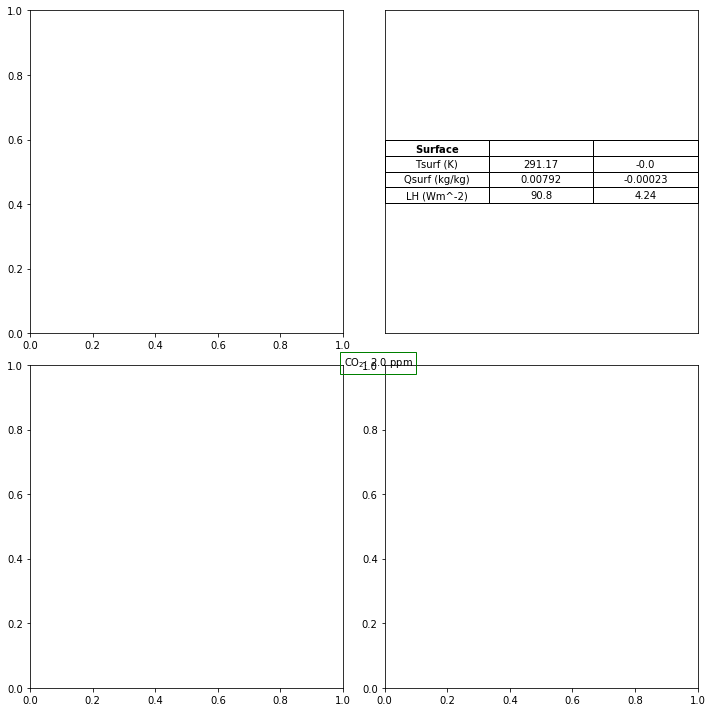

In [187]:
plotTransResponse('i2_320solar_restart_test', test_dir = 'varying_co2/320solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


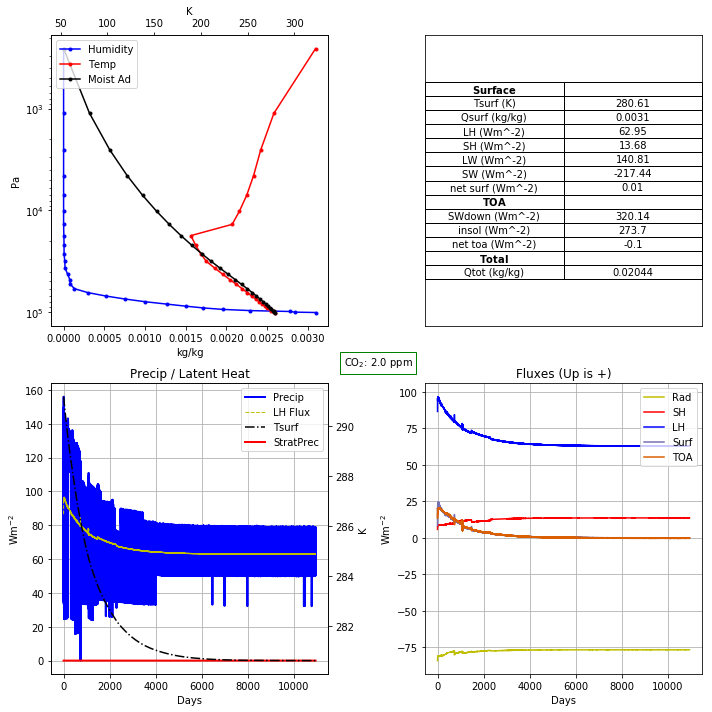

In [142]:
plotEQResponse('i2_320solar_restart_test', test_dir = 'varying_co2/320solar/')

# Control Run From Old Version

43801


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


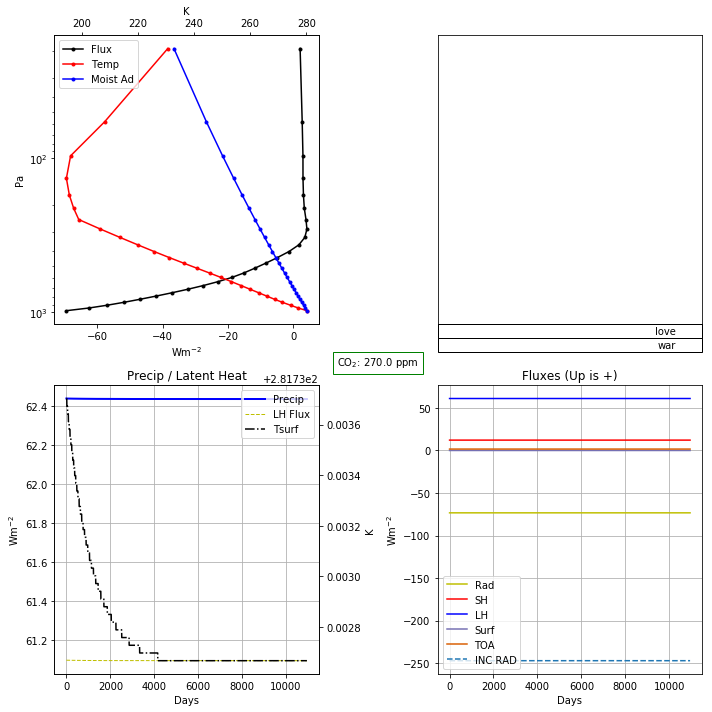

In [225]:
plot_time_series_Shanshan('shanshan_control')

# Attempts to Reproduce w/ New Version

## Defaults

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


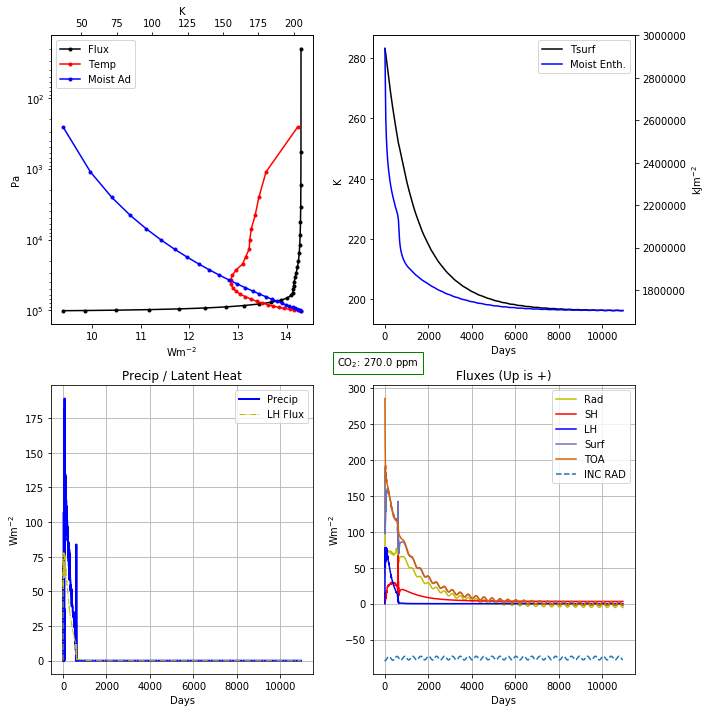

In [42]:
plot_time_series('test_a1_b1_c1', save_step = 100)

## Remove Seasonal Effects Shittily

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


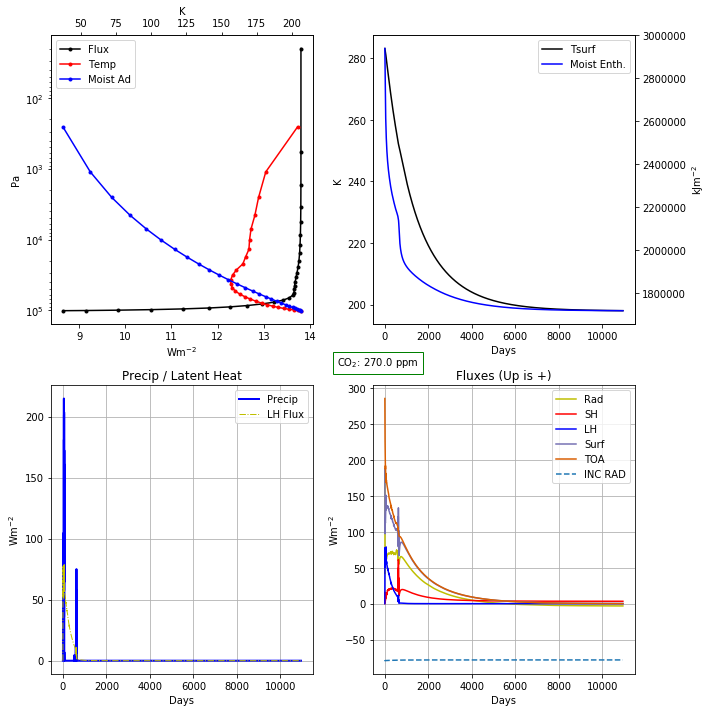

In [43]:
plot_time_series('test_a2_b1_c1', save_step = 100)

## Change Zenith Angle

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


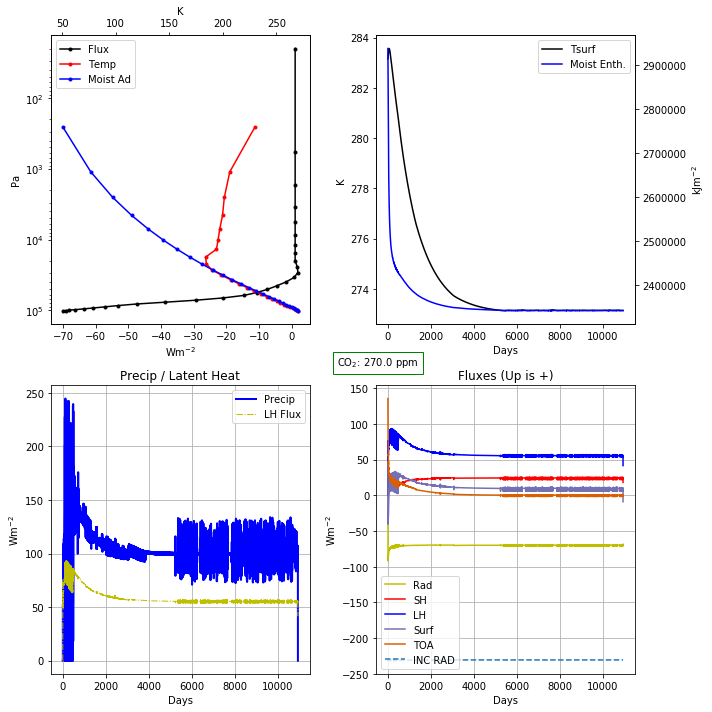

In [44]:
plot_time_series('test_a2_b1_c1_zen_32', save_step=100)

## Turn Up The Sun

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


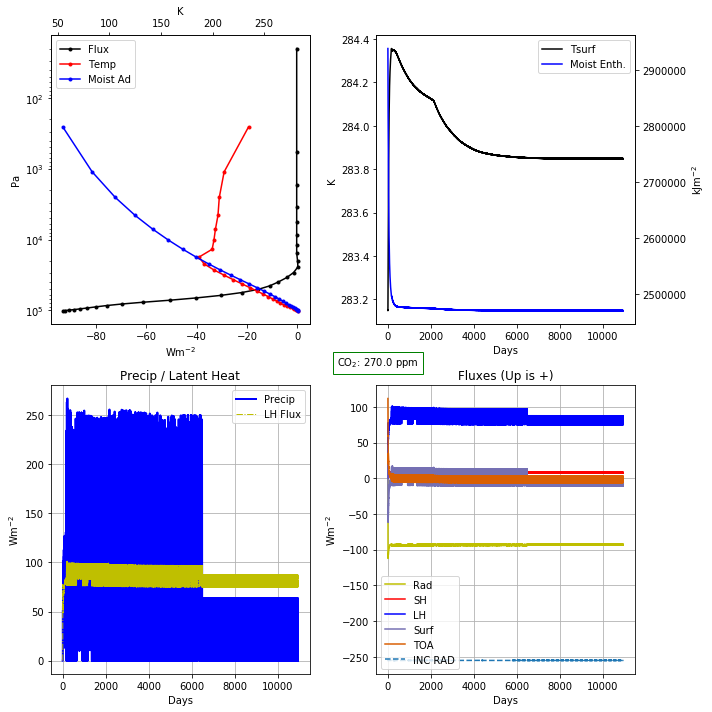

In [45]:
plot_time_series('test_a2_b1_c1_zen_32_sol_320')

## Be Smart About It

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


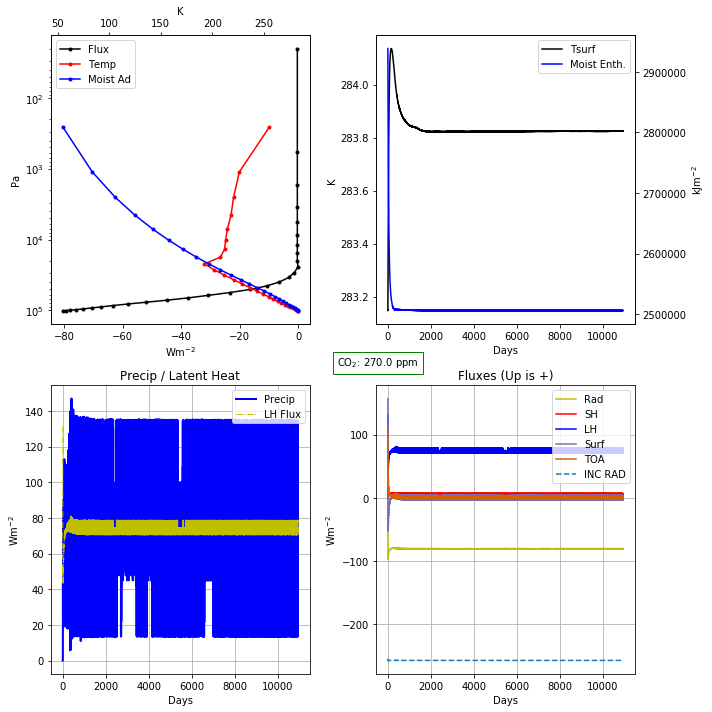

In [47]:
plot_time_series('test_a2_b1_c1_270i_939solar')

## Only Surface Wind --> Stir Convection

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


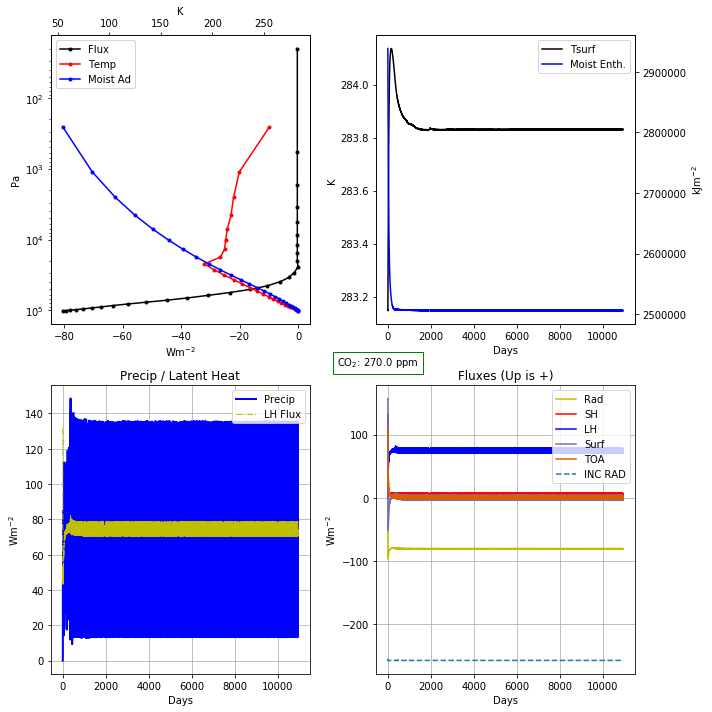

In [49]:
plot_time_series('test_a2_b1_c1_270i_939solar_usurf')

## Take Away Seasonal Effects The Smart Way

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


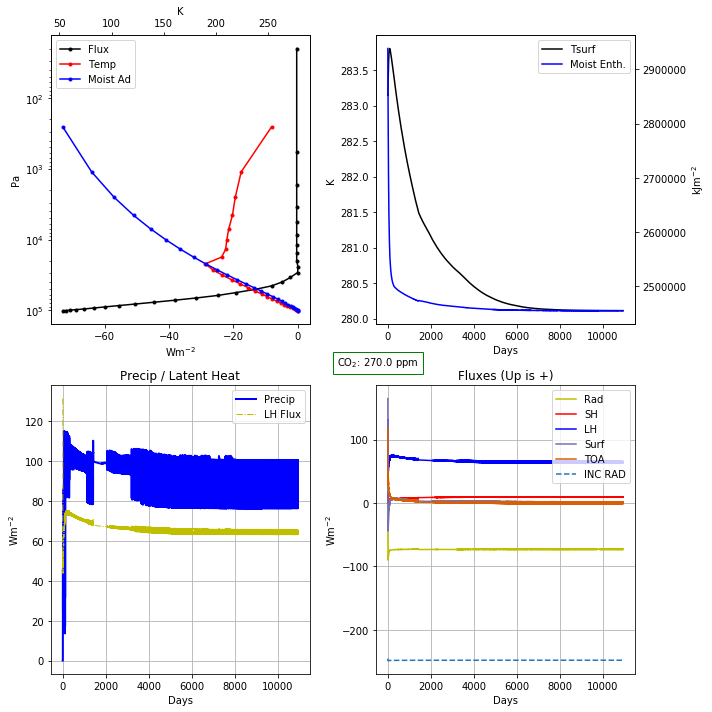

In [53]:
plot_time_series('test_a1_b1_c1_270i_939solar_usurf_noseason')

## Dry Convection Adjustment

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


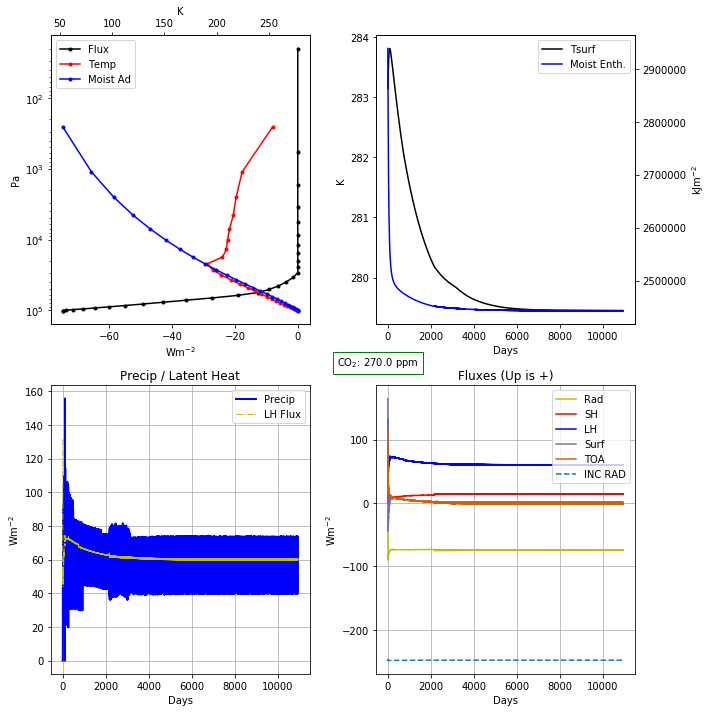

In [54]:
plot_time_series('test_a1_b1_c1_270i_939solar_dryconv_usurf_noseason')

# The Winner(s)

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


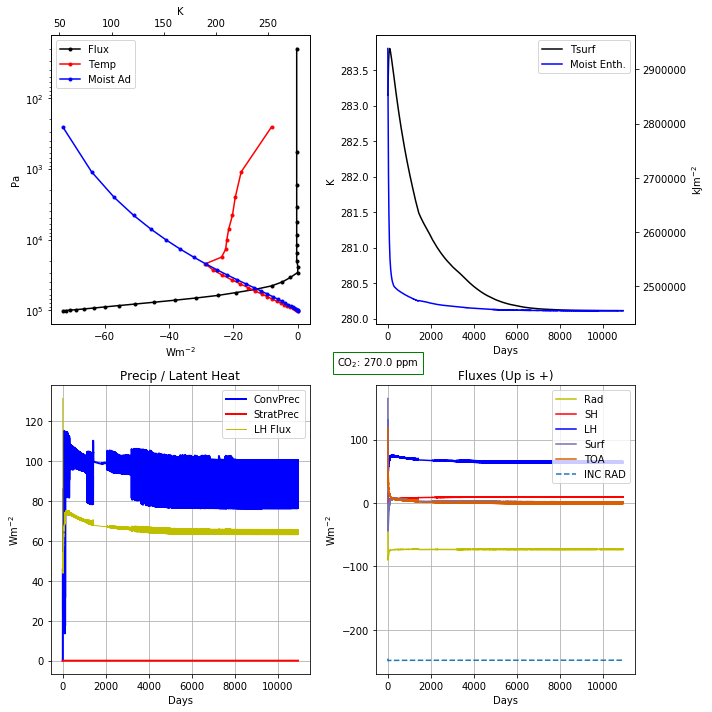

In [56]:
plot_time_series('global_control_nodryconv_strat_prec')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


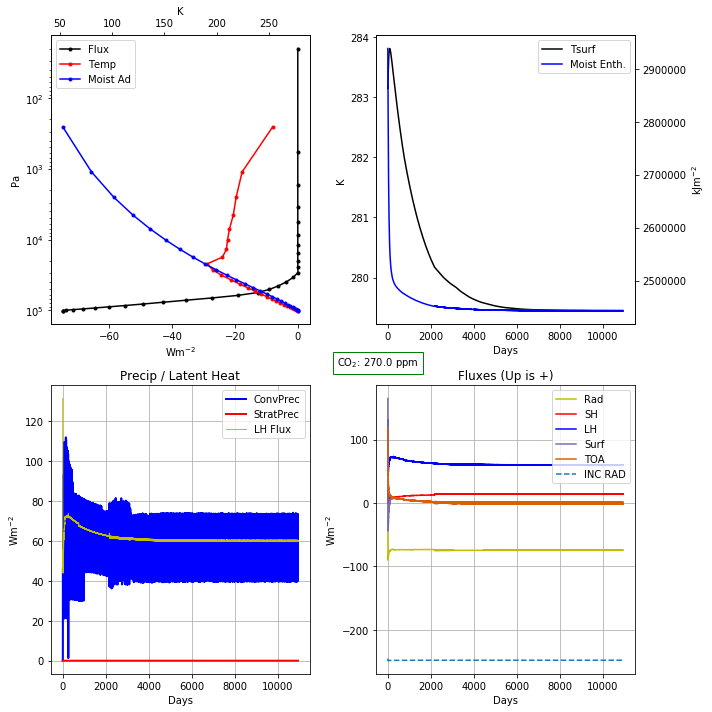

In [57]:
plot_time_series('global_control_dryconv_strat_prec')

43801


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


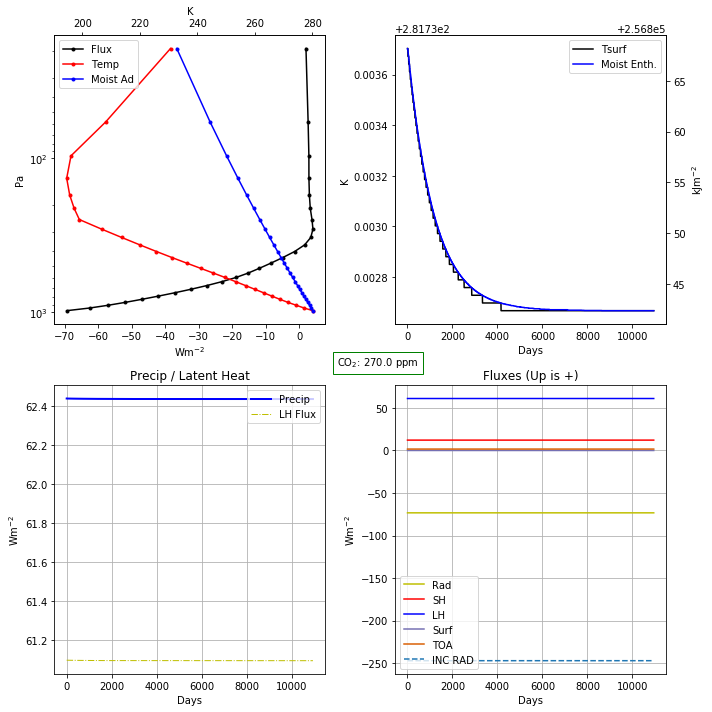

In [58]:
plot_time_series_Shanshan('shanshan_control')

# The Question Now: Is New Control Better Than Old? Will the Differences Matter?

## Old Control

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


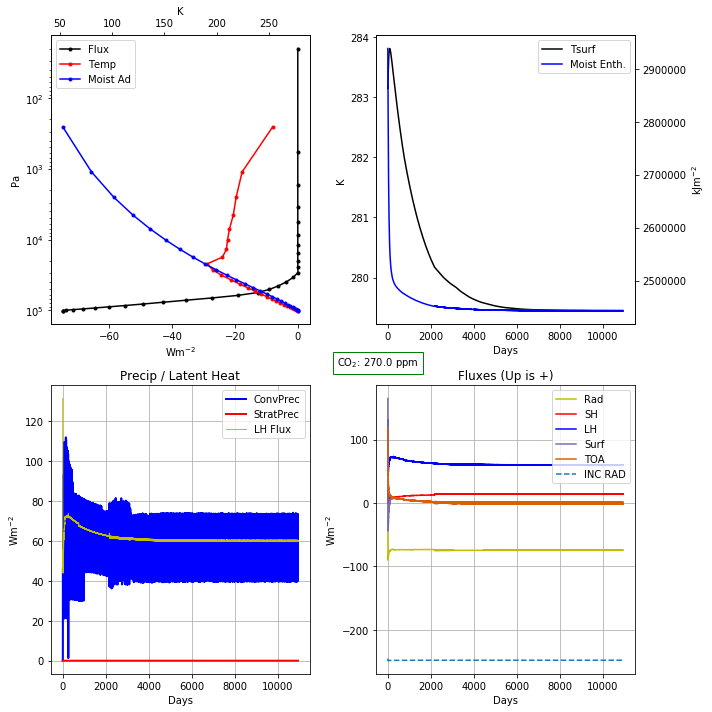

In [59]:
plot_time_series('global_control_dryconv_strat_prec')

## New Control (should be same)

In [62]:
plot_time_series('i270_290solar', test_dir = 'control/')

43800


OSError: /Users/haynesstephens1/uchi/research/climproj/climt_files/control/i270_290solar/i270_290solar_eqProfile_air_temperature.csv not found.

# Varying CO2

## 290 Solar (Global)

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


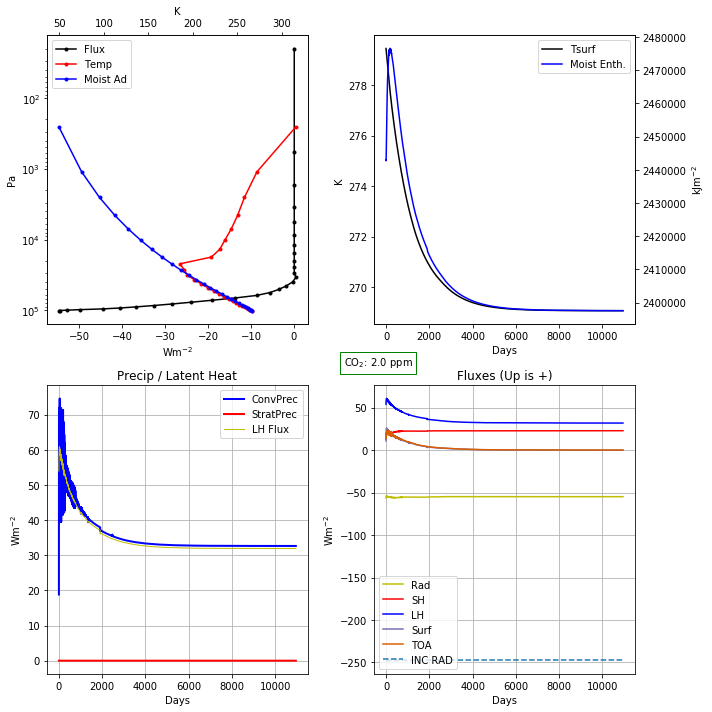

In [64]:
plot_time_series('i2_290solar', test_dir = 'varying_co2/290solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


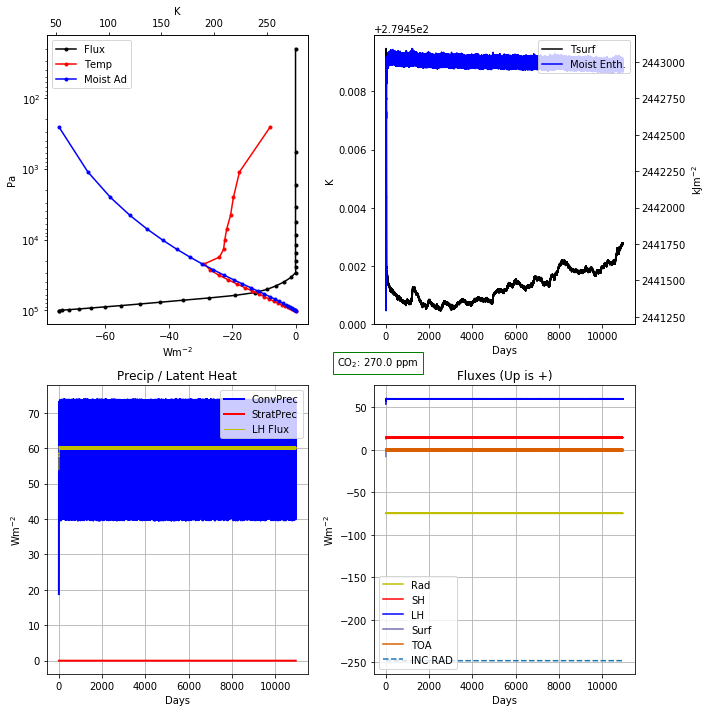

In [66]:
plot_time_series('i270_290solar', test_dir = 'varying_co2/290solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


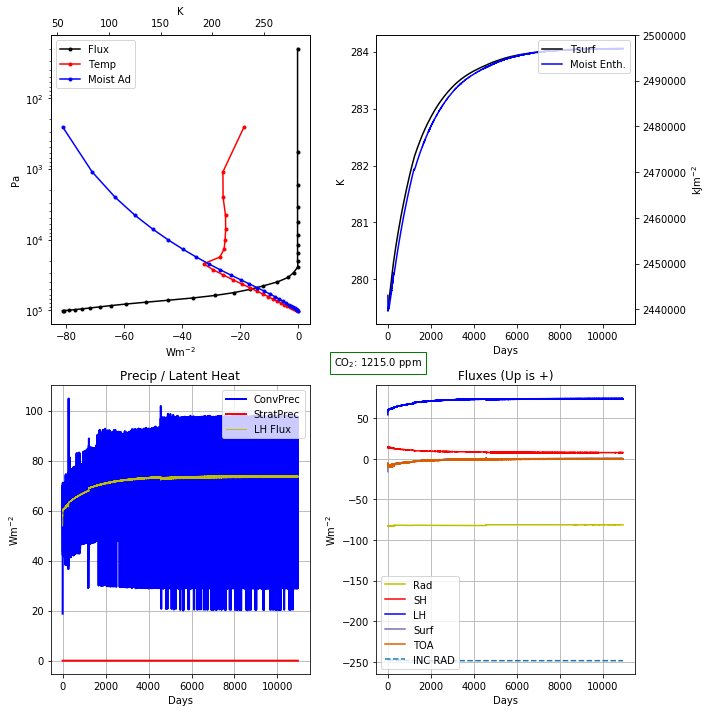

In [68]:
plot_time_series('i1215_290solar', test_dir = 'varying_co2/290solar/')

## 320 Solar (Tropics)

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


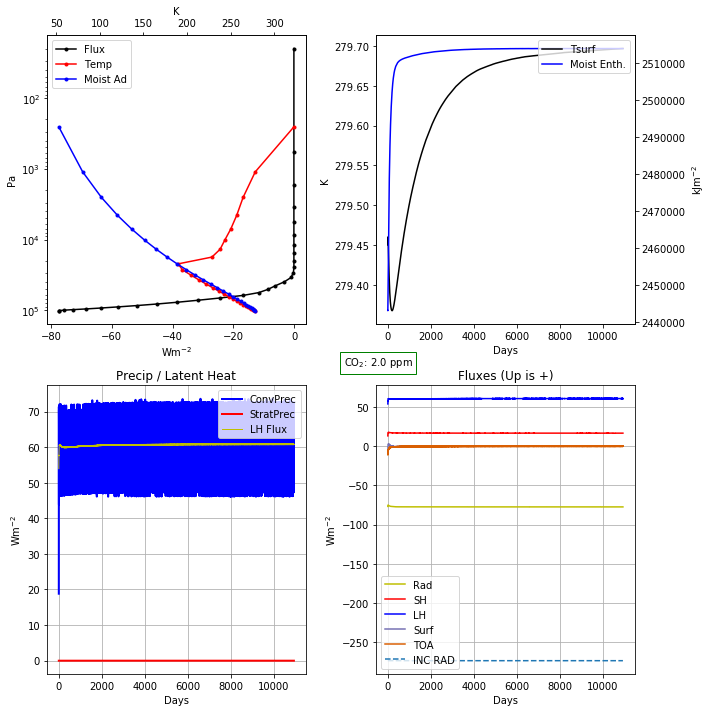

In [70]:
plot_time_series('i2_320solar', test_dir = 'varying_co2/320solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


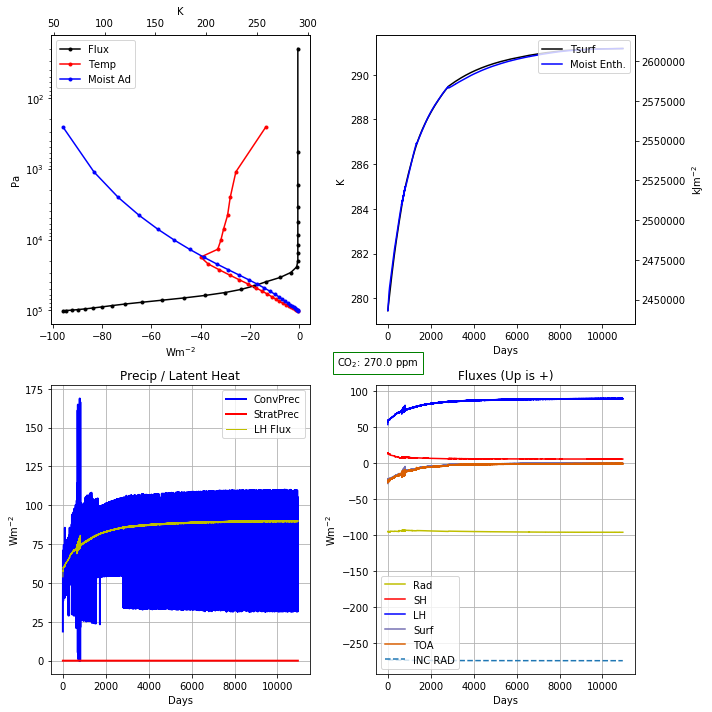

In [71]:
plot_time_series('i270_320solar', test_dir = 'varying_co2/320solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


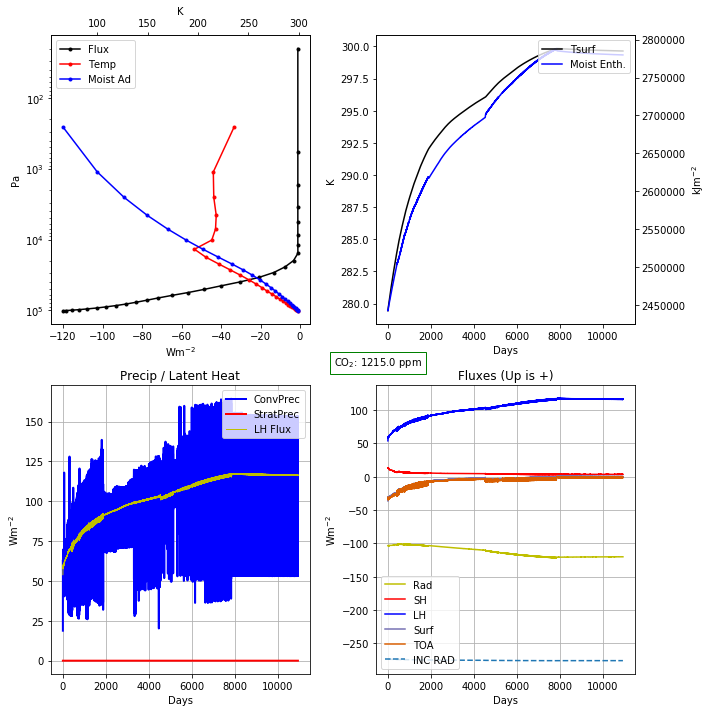

In [72]:
plot_time_series('i1215_320solar', test_dir = 'varying_co2/320solar/')

# Varying Solar

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


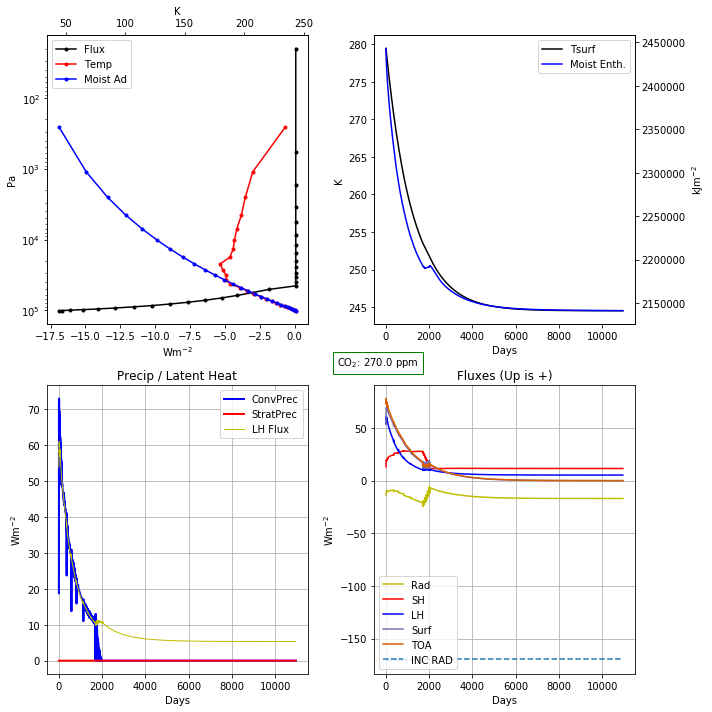

In [74]:
plot_time_series('i270_200solar', test_dir = 'varying_solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


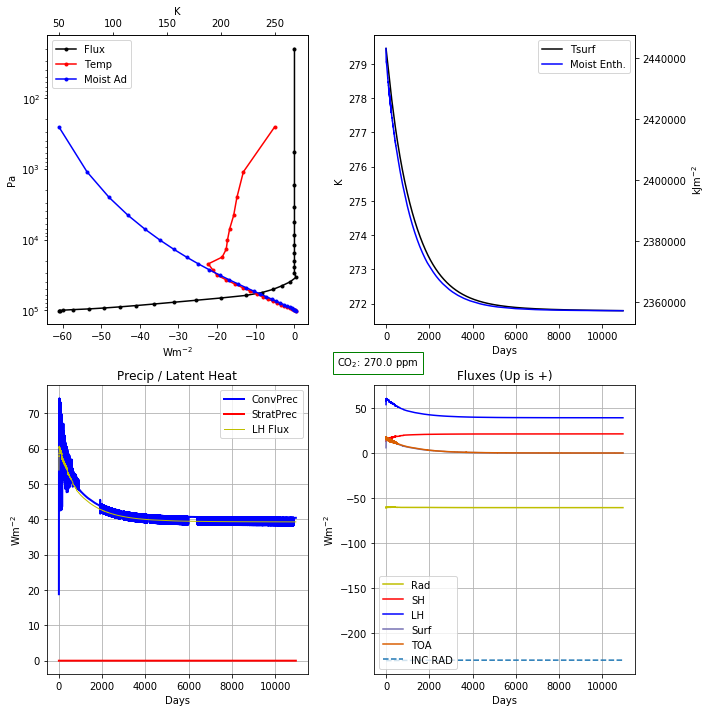

In [76]:
plot_time_series('i270_270solar', test_dir = 'varying_solar/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


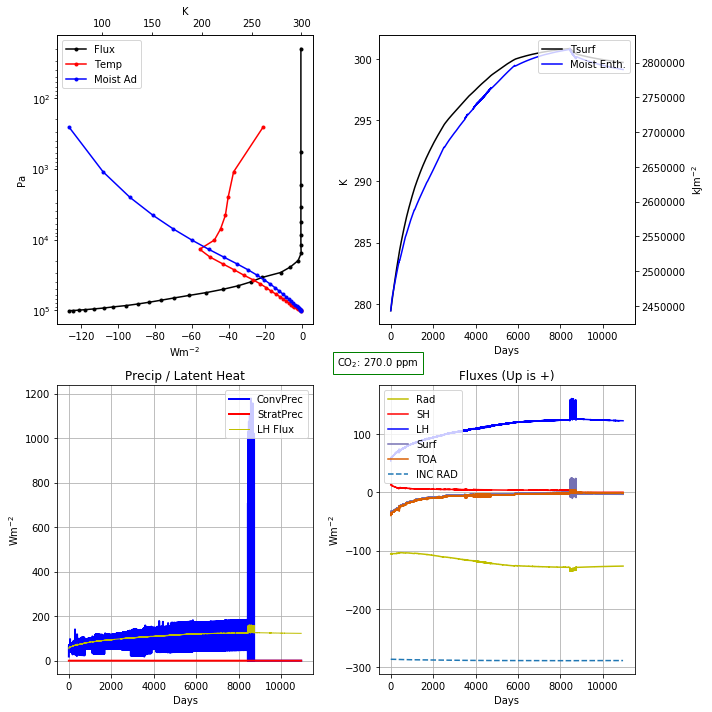

In [78]:
plot_time_series('i270_335solar', test_dir = 'varying_solar/')

# Constant Humidity Profile

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


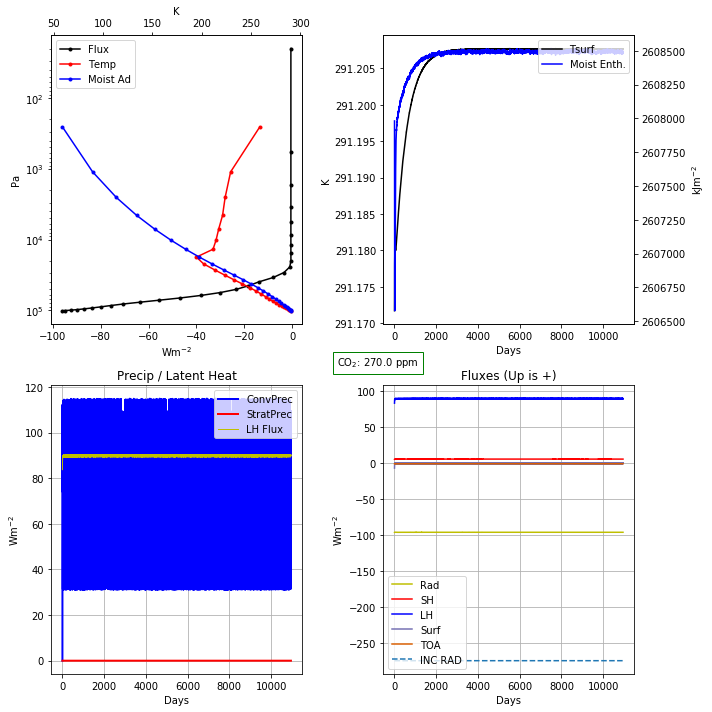

In [79]:
plot_time_series('i270_320solar_cst_q_rad', test_dir = 'varying_co2_cst_q_rad/')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


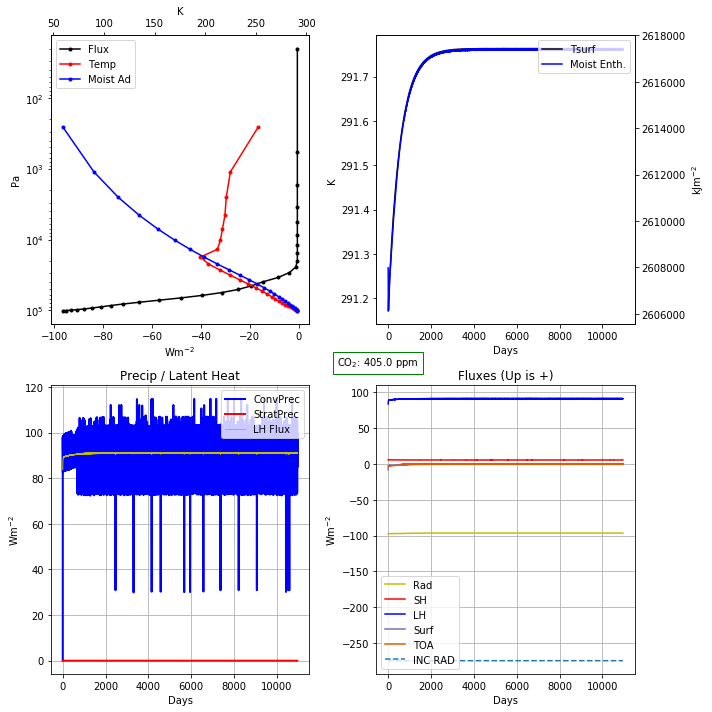

In [81]:
plot_time_series('i405_320solar_cst_q_rad', test_dir = 'varying_co2_cst_q_rad/')

# CHECKING OUT FULL RESTART FILES AND COMPARING

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


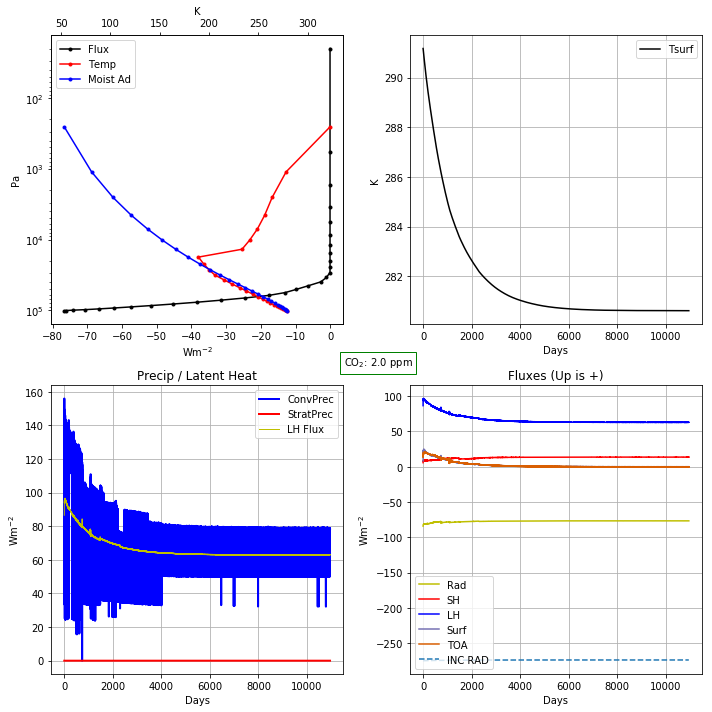

In [169]:
plot_time_series('i2_320solar_restart_test', test_dir = 'varying_co2/320solar/')